In [1]:
from google.colab import drive

# Kết nối Google Drive
drive.mount('/content/drive')



Mounted at /content/drive


# 2) Import & cấu hình chung

In [2]:
# Cài đặt các thư viện cần thiết
!pip install pyvi transformers scikit-learn pandas torch

# Kiểm tra cài đặt
try:
    import pyvi
    import transformers
    import sklearn
    import pandas
    import torch
    print("Tất cả thư viện đã được cài đặt thành công!")
except ImportError as e:
    print(f"Lỗi cài đặt thư viện: {e}. Vui lòng chạy lại lệnh pip install.")

import os, time, random, math
from typing import Dict
import numpy as np
import pandas as pd
import re
from pyvi import ViTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler
from transformers import AutoTokenizer, AutoConfig, AutoModel, get_linear_schedule_with_warmup, set_seed as hf_set_seed
from torch.optim import Adam

# Hàm set_seed để đảm bảo kết quả tái lập
def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    hf_set_seed(seed)

# Hàm định dạng thời gian cho việc theo dõi
def fmt_time(seconds: float) -> str:
    m, s = divmod(int(seconds), 60); h, m = divmod(m, 60)
    return f"{h}h {m}m {s}s" if h else f"{m}m {s}s"

# Thiết bị (GPU nếu có, nếu không thì CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
set_seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.4 MB/s eta 0:00:00
Tất cả thư viện đã được cài đặt thành công!
Device: cuda


# 3) Dataset & DataLoader

In [3]:
# Lớp TextDataset
import re
from pyvi import ViTokenizer
import pandas as pd
import torch
from torch.utils.data import Dataset
from typing import Dict, Optional, Set

class TextDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, max_len: int = 128, stop_words: Optional[Set[str]] = None):
        assert set(["id", "text", "label"]).issubset(df.columns), "CSV phải có cột 'id', 'text', 'label'."
        self.texts = df["text"].astype(str).apply(self.preprocess_text).tolist()
        self.labels = df["label"].astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.stop_words = stop_words if stop_words is not None else set([
            'là', 'của', 'và', 'trong', 'được', 'có', 'với', 'cho', 'tại', 'bởi', 'từ', 'để', 'mà'
        ])

    def preprocess_text(self, text: str) -> str:
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        words = ViTokenizer.tokenize(text).split()
        if self.stop_words:
            words = [word for word in words if word not in self.stop_words]
        return ' '.join(words)

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        text = self.texts[idx]
        label = self.labels[idx]
        enc = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
            return_token_type_ids=True
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

# 4) Mô hình PhoBERT (concat [CLS] 4 lớp cuối)

In [4]:
import torch
import torch.nn as nn
from transformers import AutoConfig, AutoModel
from typing import Optional

class TransformerCLS4Concat(nn.Module):
    def __init__(self, model_name: str = "vinai/phobert-base", num_labels: int = 2, dropout: float = 0.2):
        super().__init__()
        self.model_name = model_name  # Lưu model_name để sử dụng trong forward
        self.config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)
        self.backbone = AutoModel.from_pretrained(model_name, config=self.config)
        hidden_size = self.config.hidden_size if hasattr(self.config, 'hidden_size') else self.config.d_model
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 4, hidden_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_labels)
        )

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "output_hidden_states": True,
            "return_dict": True
        }
        if token_type_ids is not None and self.model_name in ["bert-base-multilingual-cased"]:
            inputs["token_type_ids"] = token_type_ids
        out = self.backbone(**inputs)
        hs = out.hidden_states
        cls_concat = torch.cat([hs[-i][:, 0, :] for i in range(1, 5)], dim=-1)
        logits = self.classifier(cls_concat)
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        probs = torch.softmax(logits, dim=-1)
        return {"loss": loss, "logits": logits, "probabilities": probs}

# 5) Hàm đánh giá, freeze backbone, optimizer

In [5]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import torch
import torch.nn as nn
from torch.optim import Adam

# Hàm evaluate
def evaluate(model, dataloader, device):
    model.eval()
    preds, trues, probs = [], [], []
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                token_type_ids=batch.get("token_type_ids"),
                labels=batch["labels"]
            )
            total_loss += out["loss"].item()
            logits = out["logits"]
            probabilities = out["probabilities"][:, 1].cpu().tolist()
            preds.extend(torch.argmax(logits, dim=1).cpu().tolist())
            trues.extend(batch["labels"].cpu().tolist())
            probs.extend(probabilities)
    avg_loss = total_loss / max(1, len(dataloader))
    acc = accuracy_score(trues, preds)
    p, r, f1, _ = precision_recall_fscore_support(trues, preds, average="macro", zero_division=0)
    auroc = roc_auc_score(trues, probs)
    return {
        "loss": avg_loss,
        "accuracy": acc,
        "precision_macro": p,
        "recall_macro": r,
        "f1_macro": f1,
        "auroc": auroc
    }

# Hàm freeze_backbone
def freeze_backbone(model, freeze: bool = True):
    if hasattr(model, "backbone"):
        for p in model.backbone.parameters():
            p.requires_grad = not freeze
    else:
        print("Cảnh báo: Mô hình không có thuộc tính 'backbone'.")

# Hàm get_optimizer
def get_optimizer(model, lr: float = 3e-5, weight_decay: float = 0.01):
    no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight"]
    grouped = [
        {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], "weight_decay": weight_decay},
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    return Adam(grouped, lr=lr)

# 6) Cấu hình tham số huấn luyện

In [6]:
import os
from transformers import set_seed

# Cấu hình tham số
CSV_PATH = "/content/drive/MyDrive/data/final.csv"
MODEL_NAMES = [
    "vinai/phobert-base",
   # Sửa từ vinai/bartpho-base thành vinai/bartpho-syllable
    "bert-base-multilingual-cased"
]
OUTPUT_DIR = "/content/drive/MyDrive/data/outputs"
MAX_LENS = [128, 256]
EPOCHS = 5
TRAIN_BS = 4
EVAL_BS = 32
LR = 3e-5
WARMUP_RATIO = 0.06
WEIGHT_DECAY = 0.01
VAL_SPLIT = 0.1
TEST_SPLIT = 0.2
PATIENCE = 5
SEED = 42
FP16 = True

# Tạo thư mục đầu ra cho từng mô hình
for model_name in MODEL_NAMES:
    model_output_dir = os.path.join(OUTPUT_DIR, model_name.replace("/", "_"))
    os.makedirs(model_output_dir, exist_ok=True)

set_seed(SEED)

# 7) Load dữ liệu & khởi tạo tokenizer/dataloader

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from pyvi import ViTokenizer
import re
import torch
from torch.utils.data import Dataset
from typing import Dict, Optional, Set

# Định nghĩa TextDataset để sửa lỗi stop_words
class TextDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, max_len: int = 128, stop_words: Optional[Set[str]] = None):
        assert set(["id", "text", "label"]).issubset(df.columns), "CSV phải có cột 'id', 'text', 'label'."
        self.stop_words = stop_words if stop_words is not None else set([
            'là', 'của', 'và', 'trong', 'được', 'có', 'với', 'cho', 'tại', 'bởi', 'từ', 'để', 'mà'
        ])
        self.texts = df["text"].astype(str).apply(self.preprocess_text).tolist()
        self.labels = df["label"].astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def preprocess_text(self, text: str) -> str:
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        words = ViTokenizer.tokenize(text).split()
        if self.stop_words:
            words = [word for word in words if word not in self.stop_words]
        return ' '.join(words)

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        text = self.texts[idx]
        label = self.labels[idx]
        enc = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
            return_token_type_ids=True
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

# Load dữ liệu
df = pd.read_csv(CSV_PATH)
assert set(["id", "text", "label"]).issubset(df.columns), "CSV phải có cột 'id', 'text', 'label'"
df = df.dropna(subset=["text", "label"]).reset_index(drop=True)
df["label"] = df["label"].astype(int)

train_df, temp_df = train_test_split(df, test_size=VAL_SPLIT + TEST_SPLIT, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT), stratify=temp_df["label"], random_state=SEED)

tokenizers = {model_name: AutoTokenizer.from_pretrained(model_name, use_fast=True) for model_name in MODEL_NAMES}
datasets = {}
dataloaders = {}
for model_name in MODEL_NAMES:
    datasets[model_name] = {
        "train": TextDataset(train_df, tokenizers[model_name], max_len=128),
        "val": TextDataset(val_df, tokenizers[model_name], max_len=128),
        "test": TextDataset(test_df, tokenizers[model_name], max_len=128)
    }
    dataloaders[model_name] = {
        "train": DataLoader(datasets[model_name]["train"], batch_size=TRAIN_BS, shuffle=True, num_workers=2, pin_memory=True),
        "val": DataLoader(datasets[model_name]["val"], batch_size=EVAL_BS, shuffle=False, num_workers=2, pin_memory=True),
        "test": DataLoader(datasets[model_name]["test"], batch_size=EVAL_BS, shuffle=False, num_workers=2, pin_memory=True)
    }

print(f"Kích thước tập train: {len(train_df)}, validation: {len(val_df)}, test: {len(test_df)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Kích thước tập train: 944, validation: 135, test: 271


# 8) Khởi tạo model, optimizer, scheduler

In [8]:
import torch
from torch.cuda.amp import GradScaler
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader

# Khởi tạo mô hình, optimizer, scheduler
models = {}
optimizers = {}
schedulers = {}
scalers = {}
best_f1s = {}
best_paths = {}
results = []

for max_len in MAX_LENS:
    for model_name in MODEL_NAMES:
        try:
            # Tạo dataset và dataloader cho mỗi max_len
            datasets[model_name] = {
                "train": TextDataset(train_df, tokenizers[model_name], max_len=max_len),
                "val": TextDataset(val_df, tokenizers[model_name], max_len=max_len),
                "test": TextDataset(test_df, tokenizers[model_name], max_len=max_len)
            }
            dataloaders[model_name] = {
                "train": DataLoader(datasets[model_name]["train"], batch_size=TRAIN_BS, shuffle=True, num_workers=2, pin_memory=True),
                "val": DataLoader(datasets[model_name]["val"], batch_size=EVAL_BS, shuffle=False, num_workers=2, pin_memory=True),
                "test": DataLoader(datasets[model_name]["test"], batch_size=EVAL_BS, shuffle=False, num_workers=2, pin_memory=True)
            }
            model = TransformerCLS4Concat(model_name=model_name, num_labels=2).to(device)
            models[(model_name, max_len)] = model
            optimizer = get_optimizer(model, lr=LR, weight_decay=WEIGHT_DECAY)
            optimizers[(model_name, max_len)] = optimizer
            t_total = len(dataloaders[model_name]["train"]) * EPOCHS
            num_warmup_steps = int(WARMUP_RATIO * t_total)
            scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=t_total)
            schedulers[(model_name, max_len)] = scheduler
            scalers[(model_name, max_len)] = GradScaler(enabled=FP16)
            model_output_dir = os.path.join(OUTPUT_DIR, model_name.replace("/", "_"))
            best_paths[(model_name, max_len)] = os.path.join(model_output_dir, f"best_model_maxlen_{max_len}.pt")
            best_f1s[(model_name, max_len)] = -1.0
            print(f"Model: {model_name}, MAX_LEN: {max_len}")
            print(f"Total steps: {t_total}, Warmup: {num_warmup_steps}")
        except Exception as e:
            print(f"Lỗi khi tải mô hình {model_name}: {str(e)}")
            print("Bỏ qua mô hình này và tiếp tục với mô hình tiếp theo.")
            continue

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

/tmp/ipython-input-1594327847.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scalers[(model_name, max_len)] = GradScaler(enabled=FP16)


Model: vinai/phobert-base, MAX_LEN: 128
Total steps: 1180, Warmup: 70


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

/tmp/ipython-input-1594327847.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scalers[(model_name, max_len)] = GradScaler(enabled=FP16)


Model: bert-base-multilingual-cased, MAX_LEN: 128
Total steps: 1180, Warmup: 70


/tmp/ipython-input-1594327847.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scalers[(model_name, max_len)] = GradScaler(enabled=FP16)


Model: vinai/phobert-base, MAX_LEN: 256
Total steps: 1180, Warmup: 70
Model: bert-base-multilingual-cased, MAX_LEN: 256
Total steps: 1180, Warmup: 70


/tmp/ipython-input-1594327847.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scalers[(model_name, max_len)] = GradScaler(enabled=FP16)


# 9) Train loop (Freeze epoch 1 → Unfreeze)


>> Huấn luyện mô hình: vinai/phobert-base | MAX_LEN: 128
>> Epoch 1: freeze backbone (train head) | vinai/phobert-base


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 1 | Step 50/236 | Loss 0.6936 | vinai/phobert-base
Epoch 1 | Step 100/236 | Loss 0.6777 | vinai/phobert-base
Epoch 1 | Step 150/236 | Loss 0.6566 | vinai/phobert-base
Epoch 1 | Step 200/236 | Loss 0.6445 | vinai/phobert-base
Epoch 1 | Step 236/236 | Loss 0.6328 | vinai/phobert-base
[Val] Epoch 1 | loss=0.5112 | acc=0.8963 | P=0.8963 R=0.8963 | F1=0.8963 | AUROC=0.9704 | time=0m 13s | vinai/phobert-base
>> Saved best: /content/drive/MyDrive/data/outputs/vinai_phobert-base/best_model_maxlen_128.pt | F1: 0.8962906057945567 | vinai/phobert-base
>> Epoch 2: Unfroze backbone for full fine-tuning | vinai/phobert-base


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 2 | Step 50/236 | Loss 0.5135 | vinai/phobert-base
Epoch 2 | Step 100/236 | Loss 0.4326 | vinai/phobert-base
Epoch 2 | Step 150/236 | Loss 0.4332 | vinai/phobert-base
Epoch 2 | Step 200/236 | Loss 0.4220 | vinai/phobert-base
Epoch 2 | Step 236/236 | Loss 0.4220 | vinai/phobert-base
[Val] Epoch 2 | loss=0.1842 | acc=0.9333 | P=0.9343 R=0.9332 | F1=0.9333 | AUROC=0.9794 | time=0m 30s | vinai/phobert-base
>> Saved best: /content/drive/MyDrive/data/outputs/vinai_phobert-base/best_model_maxlen_128.pt | F1: 0.9332747542424076 | vinai/phobert-base


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 3 | Step 50/236 | Loss 0.4215 | vinai/phobert-base
Epoch 3 | Step 100/236 | Loss 0.3414 | vinai/phobert-base
Epoch 3 | Step 150/236 | Loss 0.3682 | vinai/phobert-base
Epoch 3 | Step 200/236 | Loss 0.3426 | vinai/phobert-base
Epoch 3 | Step 236/236 | Loss 0.3531 | vinai/phobert-base
[Val] Epoch 3 | loss=0.4484 | acc=0.8444 | P=0.8820 R=0.8433 | F1=0.8402 | AUROC=0.9886 | time=0m 35s | vinai/phobert-base


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 4 | Step 50/236 | Loss 0.2587 | vinai/phobert-base
Epoch 4 | Step 100/236 | Loss 0.3861 | vinai/phobert-base
Epoch 4 | Step 150/236 | Loss 0.3083 | vinai/phobert-base
Epoch 4 | Step 200/236 | Loss 0.3253 | vinai/phobert-base
Epoch 4 | Step 236/236 | Loss 0.3326 | vinai/phobert-base
[Val] Epoch 4 | loss=0.1963 | acc=0.9407 | P=0.9425 R=0.9405 | F1=0.9407 | AUROC=0.9899 | time=0m 33s | vinai/phobert-base
>> Saved best: /content/drive/MyDrive/data/outputs/vinai_phobert-base/best_model_maxlen_128.pt | F1: 0.9406593406593406 | vinai/phobert-base


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 5 | Step 50/236 | Loss 0.2662 | vinai/phobert-base
Epoch 5 | Step 100/236 | Loss 0.2667 | vinai/phobert-base
Epoch 5 | Step 150/236 | Loss 0.2438 | vinai/phobert-base
Epoch 5 | Step 200/236 | Loss 0.2408 | vinai/phobert-base
Epoch 5 | Step 236/236 | Loss 0.2522 | vinai/phobert-base
[Val] Epoch 5 | loss=0.2760 | acc=0.9111 | P=0.9207 R=0.9106 | F1=0.9105 | AUROC=0.9928 | time=0m 33s | vinai/phobert-base
>> Early stopping at epoch 5 | vinai/phobert-base
[Test] loss=0.2720 | acc=0.9151 | P=0.9169 R=0.9153 | F1=0.9151 | AUROC=0.9849 | vinai/phobert-base

>> Huấn luyện mô hình: bert-base-multilingual-cased | MAX_LEN: 128
>> Epoch 1: freeze backbone (train head) | bert-base-multilingual-cased


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 1 | Step 50/236 | Loss 0.7283 | bert-base-multilingual-cased
Epoch 1 | Step 100/236 | Loss 0.7020 | bert-base-multilingual-cased
Epoch 1 | Step 150/236 | Loss 0.6794 | bert-base-multilingual-cased
Epoch 1 | Step 200/236 | Loss 0.6642 | bert-base-multilingual-cased
Epoch 1 | Step 236/236 | Loss 0.6562 | bert-base-multilingual-cased
[Val] Epoch 1 | loss=0.5425 | acc=0.7407 | P=0.8046 R=0.7424 | F1=0.7273 | AUROC=0.9111 | time=0m 8s | bert-base-multilingual-cased
>> Saved best: /content/drive/MyDrive/data/outputs/bert-base-multilingual-cased/best_model_maxlen_128.pt | F1: 0.7272727272727273 | bert-base-multilingual-cased
>> Epoch 2: Unfroze backbone for full fine-tuning | bert-base-multilingual-cased


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 2 | Step 50/236 | Loss 0.6087 | bert-base-multilingual-cased
Epoch 2 | Step 100/236 | Loss 0.5714 | bert-base-multilingual-cased
Epoch 2 | Step 150/236 | Loss 0.6116 | bert-base-multilingual-cased
Epoch 2 | Step 200/236 | Loss 0.6325 | bert-base-multilingual-cased
Epoch 2 | Step 236/236 | Loss 0.5913 | bert-base-multilingual-cased
[Val] Epoch 2 | loss=0.4853 | acc=0.8148 | P=0.8656 R=0.8134 | F1=0.8077 | AUROC=0.9671 | time=0m 36s | bert-base-multilingual-cased
>> Saved best: /content/drive/MyDrive/data/outputs/bert-base-multilingual-cased/best_model_maxlen_128.pt | F1: 0.8076813493646362 | bert-base-multilingual-cased


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 3 | Step 50/236 | Loss 0.4315 | bert-base-multilingual-cased
Epoch 3 | Step 100/236 | Loss 0.3969 | bert-base-multilingual-cased
Epoch 3 | Step 150/236 | Loss 0.4353 | bert-base-multilingual-cased
Epoch 3 | Step 200/236 | Loss 0.4112 | bert-base-multilingual-cased
Epoch 3 | Step 236/236 | Loss 0.4222 | bert-base-multilingual-cased
[Val] Epoch 3 | loss=0.2393 | acc=0.8741 | P=0.8742 R=0.8740 | F1=0.8740 | AUROC=0.9741 | time=0m 36s | bert-base-multilingual-cased
>> Saved best: /content/drive/MyDrive/data/outputs/bert-base-multilingual-cased/best_model_maxlen_128.pt | F1: 0.8740464299434718 | bert-base-multilingual-cased


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 4 | Step 50/236 | Loss 0.4103 | bert-base-multilingual-cased
Epoch 4 | Step 100/236 | Loss 0.3576 | bert-base-multilingual-cased
Epoch 4 | Step 150/236 | Loss 0.2926 | bert-base-multilingual-cased
Epoch 4 | Step 200/236 | Loss 0.3233 | bert-base-multilingual-cased
Epoch 4 | Step 236/236 | Loss 0.3257 | bert-base-multilingual-cased
[Val] Epoch 4 | loss=0.3586 | acc=0.9037 | P=0.9198 R=0.9030 | F1=0.9027 | AUROC=0.9791 | time=0m 37s | bert-base-multilingual-cased
>> Saved best: /content/drive/MyDrive/data/outputs/bert-base-multilingual-cased/best_model_maxlen_128.pt | F1: 0.9026568306617118 | bert-base-multilingual-cased


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 5 | Step 50/236 | Loss 0.2652 | bert-base-multilingual-cased
Epoch 5 | Step 100/236 | Loss 0.1855 | bert-base-multilingual-cased
Epoch 5 | Step 150/236 | Loss 0.1740 | bert-base-multilingual-cased
Epoch 5 | Step 200/236 | Loss 0.1953 | bert-base-multilingual-cased
Epoch 5 | Step 236/236 | Loss 0.1938 | bert-base-multilingual-cased
[Val] Epoch 5 | loss=0.3133 | acc=0.9185 | P=0.9210 R=0.9182 | F1=0.9184 | AUROC=0.9785 | time=0m 36s | bert-base-multilingual-cased
>> Saved best: /content/drive/MyDrive/data/outputs/bert-base-multilingual-cased/best_model_maxlen_128.pt | F1: 0.9183572488866898 | bert-base-multilingual-cased
>> Early stopping at epoch 5 | bert-base-multilingual-cased
[Test] loss=0.2770 | acc=0.9114 | P=0.9115 R=0.9114 | F1=0.9114 | AUROC=0.9810 | bert-base-multilingual-cased

>> Huấn luyện mô hình: vinai/phobert-base | MAX_LEN: 256
>> Epoch 1: freeze backbone (train head) | vinai/phobert-base


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 1 | Step 50/236 | Loss 0.6813 | vinai/phobert-base
Epoch 1 | Step 100/236 | Loss 0.6722 | vinai/phobert-base
Epoch 1 | Step 150/236 | Loss 0.6524 | vinai/phobert-base
Epoch 1 | Step 200/236 | Loss 0.6358 | vinai/phobert-base
Epoch 1 | Step 236/236 | Loss 0.6266 | vinai/phobert-base
[Val] Epoch 1 | loss=0.5021 | acc=0.8889 | P=0.8897 R=0.8887 | F1=0.8888 | AUROC=0.9693 | time=0m 9s | vinai/phobert-base
>> Saved best: /content/drive/MyDrive/data/outputs/vinai_phobert-base/best_model_maxlen_256.pt | F1: 0.8887912570706793 | vinai/phobert-base
>> Epoch 2: Unfroze backbone for full fine-tuning | vinai/phobert-base


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 2 | Step 50/236 | Loss 0.5107 | vinai/phobert-base
Epoch 2 | Step 100/236 | Loss 0.4315 | vinai/phobert-base
Epoch 2 | Step 150/236 | Loss 0.4400 | vinai/phobert-base
Epoch 2 | Step 200/236 | Loss 0.4115 | vinai/phobert-base
Epoch 2 | Step 236/236 | Loss 0.3867 | vinai/phobert-base
[Val] Epoch 2 | loss=0.2189 | acc=0.9185 | P=0.9210 R=0.9182 | F1=0.9184 | AUROC=0.9765 | time=0m 32s | vinai/phobert-base
>> Saved best: /content/drive/MyDrive/data/outputs/vinai_phobert-base/best_model_maxlen_256.pt | F1: 0.9183572488866898 | vinai/phobert-base


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 3 | Step 50/236 | Loss 0.2979 | vinai/phobert-base
Epoch 3 | Step 100/236 | Loss 0.2943 | vinai/phobert-base
Epoch 3 | Step 150/236 | Loss 0.3249 | vinai/phobert-base
Epoch 3 | Step 200/236 | Loss 0.3277 | vinai/phobert-base
Epoch 3 | Step 236/236 | Loss 0.3321 | vinai/phobert-base
[Val] Epoch 3 | loss=0.1435 | acc=0.9333 | P=0.9359 R=0.9331 | F1=0.9332 | AUROC=0.9897 | time=0m 33s | vinai/phobert-base
>> Saved best: /content/drive/MyDrive/data/outputs/vinai_phobert-base/best_model_maxlen_256.pt | F1: 0.9332013854527461 | vinai/phobert-base


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 4 | Step 50/236 | Loss 0.3329 | vinai/phobert-base
Epoch 4 | Step 100/236 | Loss 0.2936 | vinai/phobert-base
Epoch 4 | Step 150/236 | Loss 0.2982 | vinai/phobert-base
Epoch 4 | Step 200/236 | Loss 0.3101 | vinai/phobert-base
Epoch 4 | Step 236/236 | Loss 0.3109 | vinai/phobert-base
[Val] Epoch 4 | loss=0.1552 | acc=0.9407 | P=0.9407 R=0.9407 | F1=0.9407 | AUROC=0.9899 | time=0m 32s | vinai/phobert-base
>> Saved best: /content/drive/MyDrive/data/outputs/vinai_phobert-base/best_model_maxlen_256.pt | F1: 0.940737489025461 | vinai/phobert-base


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 5 | Step 50/236 | Loss 0.1998 | vinai/phobert-base
Epoch 5 | Step 100/236 | Loss 0.2060 | vinai/phobert-base
Epoch 5 | Step 150/236 | Loss 0.2144 | vinai/phobert-base
Epoch 5 | Step 200/236 | Loss 0.2259 | vinai/phobert-base
Epoch 5 | Step 236/236 | Loss 0.2233 | vinai/phobert-base
[Val] Epoch 5 | loss=0.2762 | acc=0.8963 | P=0.9097 R=0.8956 | F1=0.8953 | AUROC=0.9917 | time=0m 33s | vinai/phobert-base
>> Early stopping at epoch 5 | vinai/phobert-base
[Test] loss=0.1861 | acc=0.9483 | P=0.9485 R=0.9483 | F1=0.9483 | AUROC=0.9881 | vinai/phobert-base

>> Huấn luyện mô hình: bert-base-multilingual-cased | MAX_LEN: 256
>> Epoch 1: freeze backbone (train head) | bert-base-multilingual-cased


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 1 | Step 50/236 | Loss 0.7117 | bert-base-multilingual-cased
Epoch 1 | Step 100/236 | Loss 0.6836 | bert-base-multilingual-cased
Epoch 1 | Step 150/236 | Loss 0.6610 | bert-base-multilingual-cased
Epoch 1 | Step 200/236 | Loss 0.6419 | bert-base-multilingual-cased
Epoch 1 | Step 236/236 | Loss 0.6253 | bert-base-multilingual-cased
[Val] Epoch 1 | loss=0.5103 | acc=0.7926 | P=0.8023 R=0.7919 | F1=0.7907 | AUROC=0.8903 | time=0m 8s | bert-base-multilingual-cased
>> Saved best: /content/drive/MyDrive/data/outputs/bert-base-multilingual-cased/best_model_maxlen_256.pt | F1: 0.7906513070447496 | bert-base-multilingual-cased
>> Epoch 2: Unfroze backbone for full fine-tuning | bert-base-multilingual-cased


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 2 | Step 50/236 | Loss 0.5772 | bert-base-multilingual-cased
Epoch 2 | Step 100/236 | Loss 0.5408 | bert-base-multilingual-cased
Epoch 2 | Step 150/236 | Loss 0.5149 | bert-base-multilingual-cased
Epoch 2 | Step 200/236 | Loss 0.5456 | bert-base-multilingual-cased
Epoch 2 | Step 236/236 | Loss 0.5315 | bert-base-multilingual-cased
[Val] Epoch 2 | loss=0.3710 | acc=0.8296 | P=0.8515 R=0.8306 | F1=0.8272 | AUROC=0.9605 | time=0m 34s | bert-base-multilingual-cased
>> Saved best: /content/drive/MyDrive/data/outputs/bert-base-multilingual-cased/best_model_maxlen_256.pt | F1: 0.8272024041404642 | bert-base-multilingual-cased


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 3 | Step 50/236 | Loss 0.4446 | bert-base-multilingual-cased
Epoch 3 | Step 100/236 | Loss 0.4967 | bert-base-multilingual-cased
Epoch 3 | Step 150/236 | Loss 0.5141 | bert-base-multilingual-cased
Epoch 3 | Step 200/236 | Loss 0.4945 | bert-base-multilingual-cased
Epoch 3 | Step 236/236 | Loss 0.4766 | bert-base-multilingual-cased
[Val] Epoch 3 | loss=0.2076 | acc=0.8963 | P=0.8966 R=0.8964 | F1=0.8963 | AUROC=0.9748 | time=0m 37s | bert-base-multilingual-cased
>> Saved best: /content/drive/MyDrive/data/outputs/bert-base-multilingual-cased/best_model_maxlen_256.pt | F1: 0.8962906057945567 | bert-base-multilingual-cased


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 4 | Step 50/236 | Loss 0.3572 | bert-base-multilingual-cased
Epoch 4 | Step 100/236 | Loss 0.3224 | bert-base-multilingual-cased
Epoch 4 | Step 150/236 | Loss 0.3658 | bert-base-multilingual-cased
Epoch 4 | Step 200/236 | Loss 0.3429 | bert-base-multilingual-cased
Epoch 4 | Step 236/236 | Loss 0.3703 | bert-base-multilingual-cased
[Val] Epoch 4 | loss=0.4061 | acc=0.8593 | P=0.8831 R=0.8602 | F1=0.8573 | AUROC=0.9776 | time=0m 37s | bert-base-multilingual-cased


/tmp/ipython-input-2394816489.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=FP16):


Epoch 5 | Step 50/236 | Loss 0.2616 | bert-base-multilingual-cased
Epoch 5 | Step 100/236 | Loss 0.2381 | bert-base-multilingual-cased
Epoch 5 | Step 150/236 | Loss 0.1982 | bert-base-multilingual-cased
Epoch 5 | Step 200/236 | Loss 0.2053 | bert-base-multilingual-cased
Epoch 5 | Step 236/236 | Loss 0.2103 | bert-base-multilingual-cased
[Val] Epoch 5 | loss=0.2203 | acc=0.9259 | P=0.9259 R=0.9259 | F1=0.9259 | AUROC=0.9805 | time=0m 35s | bert-base-multilingual-cased
>> Saved best: /content/drive/MyDrive/data/outputs/bert-base-multilingual-cased/best_model_maxlen_256.pt | F1: 0.9259218612818262 | bert-base-multilingual-cased
>> Early stopping at epoch 5 | bert-base-multilingual-cased
[Test] loss=0.2655 | acc=0.9114 | P=0.9115 R=0.9115 | F1=0.9114 | AUROC=0.9762 | bert-base-multilingual-cased

Kết quả đã được lưu vào: /content/drive/MyDrive/data/outputs/test_results.csv


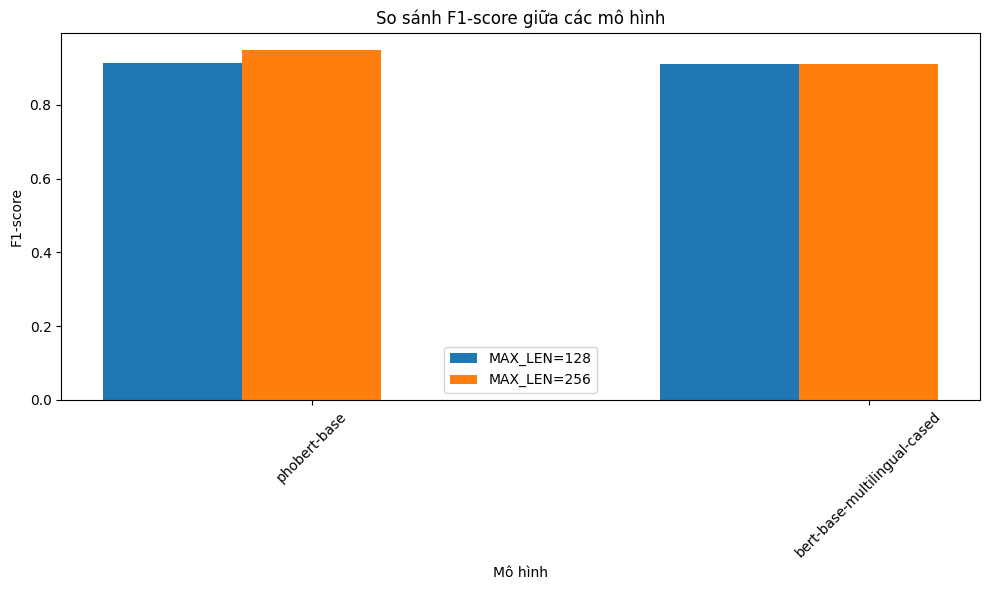

In [9]:
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt  # Thêm matplotlib để vẽ biểu đồ

# Danh sách để lưu kết quả test
results = []

# Huấn luyện và đánh giá cho từng mô hình và MAX_LEN
for max_len in MAX_LENS:
    for model_name in MODEL_NAMES:
        print(f"\n>> Huấn luyện mô hình: {model_name} | MAX_LEN: {max_len}")
        model = models[(model_name, max_len)]
        optimizer = optimizers[(model_name, max_len)]
        scheduler = schedulers[(model_name, max_len)]
        scaler = scalers[(model_name, max_len)]
        best_f1 = best_f1s[(model_name, max_len)]
        best_path = best_paths[(model_name, max_len)]

        freeze_backbone(model, True)
        print(f">> Epoch 1: freeze backbone (train head) | {model_name}")

        no_improve = 0
        for epoch in range(1, EPOCHS + 1):
            model.train()
            if epoch == 2:
                freeze_backbone(model, False)
                print(f">> Epoch {epoch}: Unfroze backbone for full fine-tuning | {model_name}")

            start = time.time()
            running_loss = 0.0
            optimizer.zero_grad()

            for step, batch in enumerate(dataloaders[model_name]["train"], start=1):
                batch = {k: v.to(device) for k, v in batch.items()}
                with torch.cuda.amp.autocast(enabled=FP16):
                    out = model(
                        input_ids=batch["input_ids"],
                        attention_mask=batch["attention_mask"],
                        token_type_ids=batch.get("token_type_ids"),
                        labels=batch["labels"]
                    )
                    loss = out["loss"]

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()

                running_loss += loss.item()
                if step % 50 == 0 or step == len(dataloaders[model_name]["train"]):
                    print(f"Epoch {epoch} | Step {step}/{len(dataloaders[model_name]['train'])} | "
                          f"Loss {running_loss/step:.4f} | {model_name}")

            metrics = evaluate(model, dataloaders[model_name]["val"], device)
            print(f"[Val] Epoch {epoch} | loss={metrics['loss']:.4f} | acc={metrics['accuracy']:.4f} "
                  f"| P={metrics['precision_macro']:.4f} R={metrics['recall_macro']:.4f} "
                  f"| F1={metrics['f1_macro']:.4f} | AUROC={metrics['auroc']:.4f} "
                  f"| time={fmt_time(time.time()-start)} | {model_name}")

            if metrics["f1_macro"] > best_f1:
                best_f1 = metrics["f1_macro"]
                best_f1s[(model_name, max_len)] = best_f1
                torch.save({
                    "model_state_dict": model.state_dict(),
                    "f1_macro": best_f1,
                    "model_name": model_name,
                    "max_len": max_len
                }, best_path)
                print(f">> Saved best: {best_path} | F1: {best_f1} | {model_name}")

            # Early stopping
            if metrics["f1_macro"] > best_f1:
                no_improve = 0
            else:
                no_improve += 1
            if no_improve >= PATIENCE:
                print(f">> Early stopping at epoch {epoch} | {model_name}")
                break

        try:
            model.load_state_dict(torch.load(best_path)["model_state_dict"])
            test_metrics = evaluate(model, dataloaders[model_name]["test"], device)
            print(f"[Test] loss={test_metrics['loss']:.4f} | acc={test_metrics['accuracy']:.4f} "
                  f"| P={test_metrics['precision_macro']:.4f} R={test_metrics['recall_macro']:.4f} "
                  f"| F1={test_metrics['f1_macro']:.4f} | AUROC={test_metrics['auroc']:.4f} | {model_name}")

            results.append({
                "model_name": model_name,
                "max_len": max_len,
                "loss": test_metrics["loss"],
                "accuracy": test_metrics["accuracy"],
                "precision_macro": test_metrics["precision_macro"],
                "recall_macro": test_metrics["recall_macro"],
                "f1_macro": test_metrics["f1_macro"],
                "auroc": test_metrics["auroc"]
            })
        except Exception as e:
            print(f"Lỗi khi đánh giá mô hình {model_name} trên tập test: {str(e)}")
            continue

results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(OUTPUT_DIR, "test_results.csv"), index=False)
print(f"\nKết quả đã được lưu vào: {os.path.join(OUTPUT_DIR, 'test_results.csv')}")

# Tạo biểu đồ so sánh F1-score với matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
index = np.arange(len(MODEL_NAMES))

for i, max_len in enumerate(MAX_LENS):
    f1_scores = []
    for model_name in MODEL_NAMES:
        f1 = results_df[(results_df["model_name"] == model_name) & (results_df["max_len"] == max_len)]["f1_macro"].values
        f1_scores.append(f1[0] if len(f1) > 0 else 0)
    ax.bar(index + i * bar_width, f1_scores, bar_width, label=f"MAX_LEN={max_len}")

ax.set_xlabel("Mô hình")
ax.set_ylabel("F1-score")
ax.set_title("So sánh F1-score giữa các mô hình")
ax.set_xticks(index + bar_width)
ax.set_xticklabels([name.split("/")[-1] for name in MODEL_NAMES], rotation=45)
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "f1_comparison.png"))
plt.show()

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Dữ liệu val metrics theo epoch (từ output)
history = {
    "vinai/phobert-base_128": {
        "val_loss": [0.5112, 0.1842, 0.4484, 0.1963, 0.2760],
        "val_f1": [0.8963, 0.9333, 0.8402, 0.9407, 0.9105],
        "val_auroc": [0.9704, 0.9794, 0.9886, 0.9899, 0.9928]
    },
    "bert-base-multilingual-cased_128": {
        "val_loss": [0.5425, 0.4853, 0.2393, 0.3586, 0.3133],
        "val_f1": [0.7273, 0.8077, 0.8740, 0.9027, 0.9184],
        "val_auroc": [0.9111, 0.9671, 0.9741, 0.9791, 0.9785]
    },
    "vinai/phobert-base_256": {
        "val_loss": [0.5021, 0.2189, 0.1435, 0.1552, 0.2762],
        "val_f1": [0.8888, 0.9184, 0.9332, 0.9407, 0.8953],
        "val_auroc": [0.9693, 0.9765, 0.9897, 0.9899, 0.9917]
    },
    "bert-base-multilingual-cased_256": {
        "val_loss": [0.5103, 0.3710, 0.2076, 0.4061, 0.2203],
        "val_f1": [0.7907, 0.8272, 0.8963, 0.8573, 0.9259],
        "val_auroc": [0.8903, 0.9605, 0.9748, 0.9776, 0.9805]
    }
}

# Dữ liệu test metrics (từ output)
test_results = {
    "vinai/phobert-base_128": {"loss": 0.2720, "acc": 0.9151, "f1": 0.9151, "auroc": 0.9849},
    "bert-base-multilingual-cased_128": {"loss": 0.2770, "acc": 0.9114, "f1": 0.9114, "auroc": 0.9810},
    "vinai/phobert-base_256": {"loss": 0.1861, "acc": 0.9483, "f1": 0.9483, "auroc": 0.9881},
    "bert-base-multilingual-cased_256": {"loss": 0.2655, "acc": 0.9114, "f1": 0.9114, "auroc": 0.9762}
}

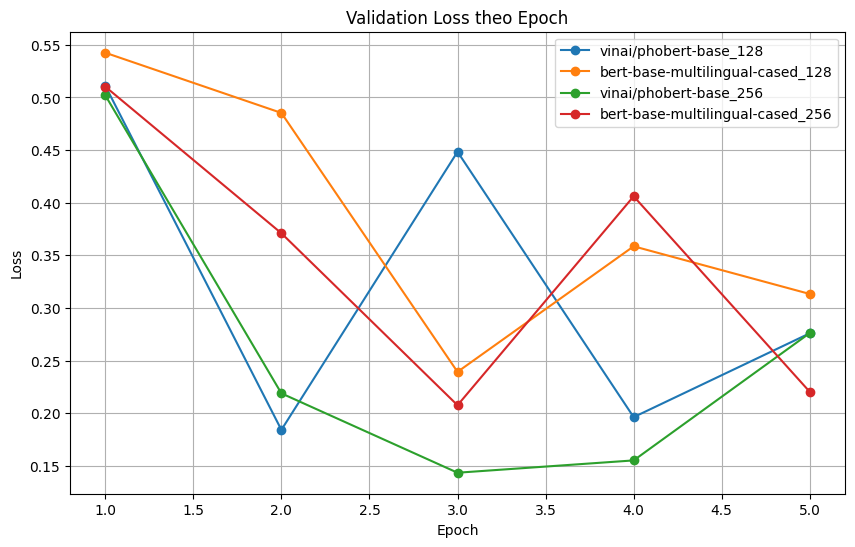

Biểu đồ lưu tại: /content/drive/MyDrive/data/outputs/val_loss_curve.png


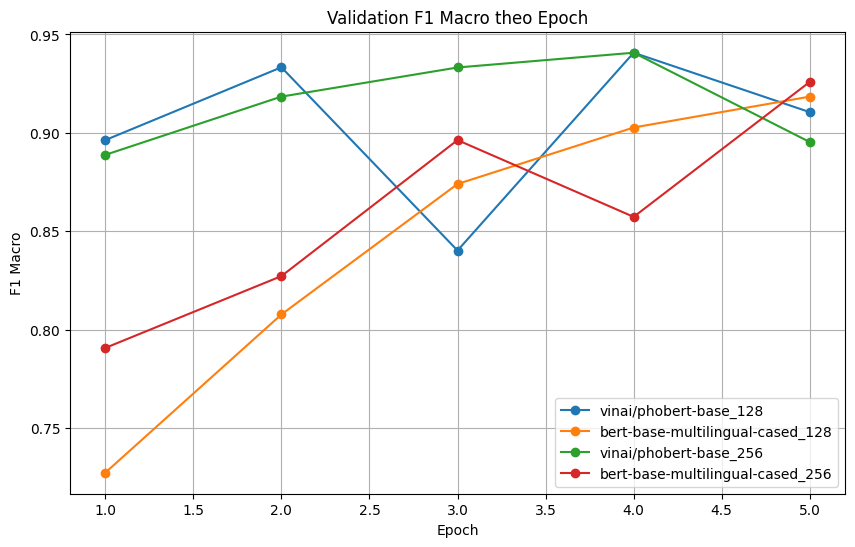

Biểu đồ lưu tại: /content/drive/MyDrive/data/outputs/val_f1_curve.png


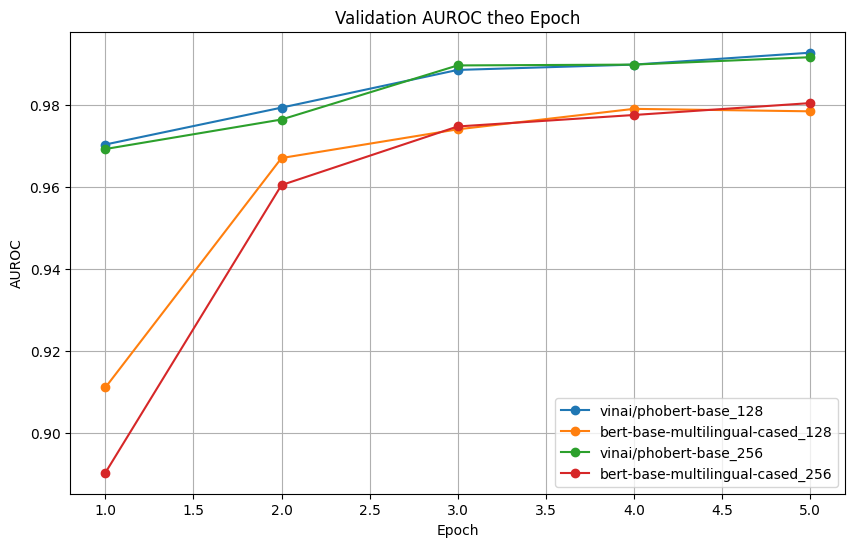

Biểu đồ lưu tại: /content/drive/MyDrive/data/outputs/val_auroc_curve.png


In [14]:
# Hàm vẽ curve cho từng metric
def plot_val_curves(history, output_dir, metric="val_loss", ylabel="Loss", title_prefix="Validation"):
    plt.figure(figsize=(10, 6))
    epochs = range(1, 6)  # 5 epochs
    for model_name, metrics in history.items():
        plt.plot(epochs, metrics[metric], marker='o', label=model_name)
    plt.title(f"{title_prefix} {ylabel} theo Epoch")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(output_dir, f"{metric}_curve.png")
    plt.savefig(plot_path)
    plt.show()
    print(f"Biểu đồ lưu tại: {plot_path}")

# Vẽ 3 curve: Loss, F1, AUROC
OUTPUT_DIR = "/content/drive/MyDrive/data/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

plot_val_curves(history, OUTPUT_DIR, metric="val_loss", ylabel="Loss", title_prefix="Validation")
plot_val_curves(history, OUTPUT_DIR, metric="val_f1", ylabel="F1 Macro", title_prefix="Validation")
plot_val_curves(history, OUTPUT_DIR, metric="val_auroc", ylabel="AUROC", title_prefix="Validation")

/tmp/ipython-input-2667770795.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=scores, palette="viridis")


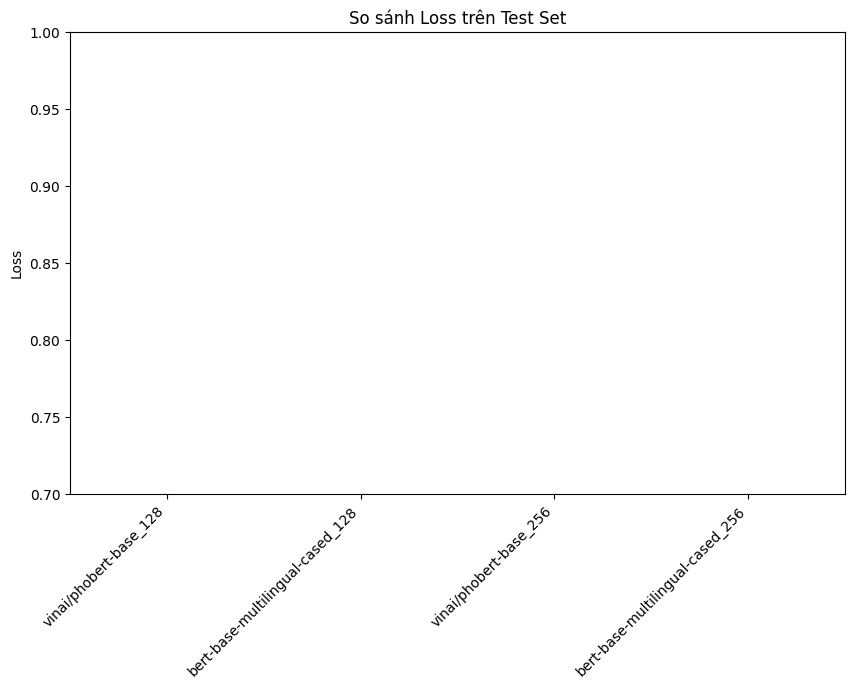

Biểu đồ lưu tại: /content/drive/MyDrive/data/outputs/test_loss_bar.png


/tmp/ipython-input-2667770795.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=scores, palette="viridis")


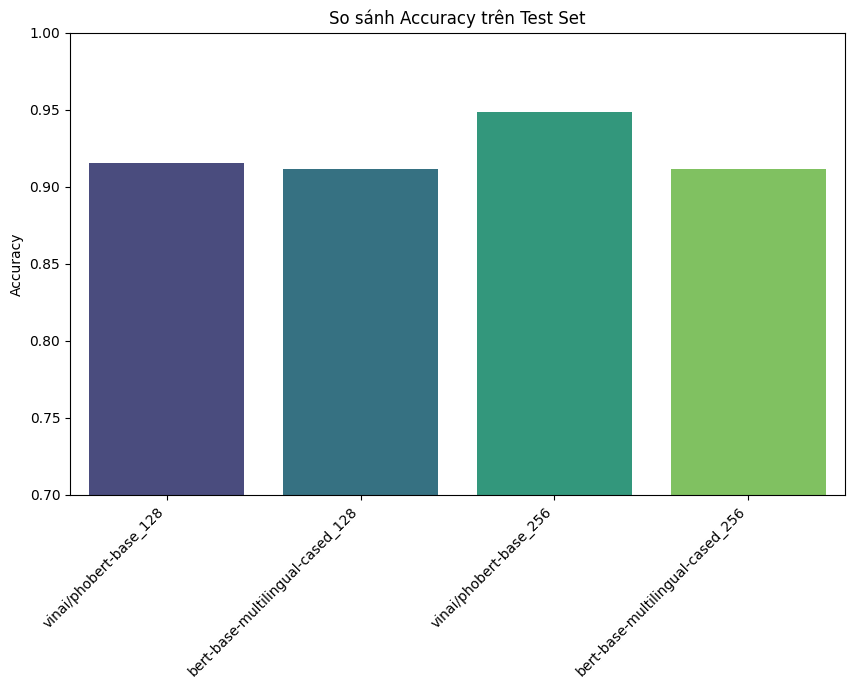

Biểu đồ lưu tại: /content/drive/MyDrive/data/outputs/test_acc_bar.png


/tmp/ipython-input-2667770795.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=scores, palette="viridis")


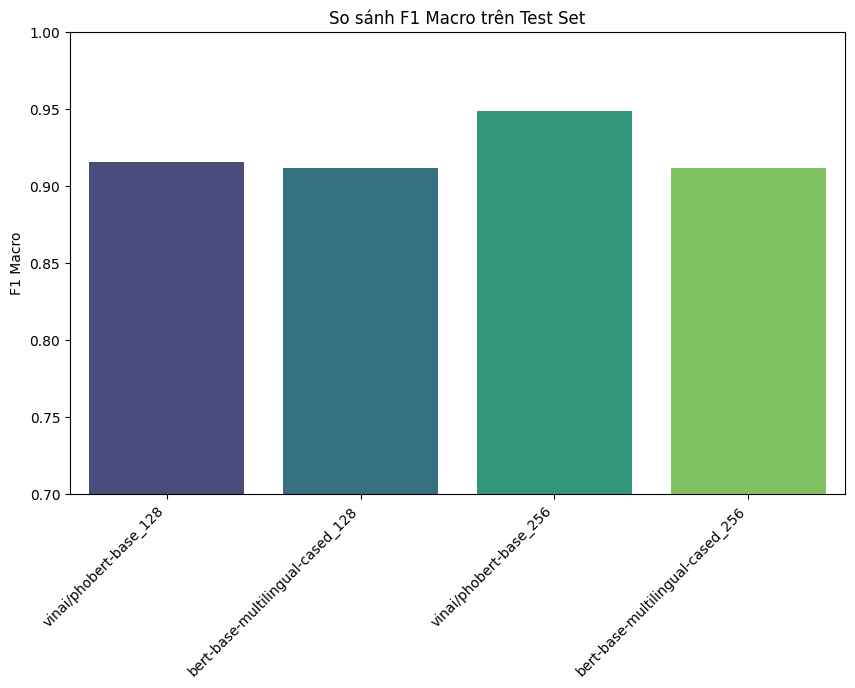

Biểu đồ lưu tại: /content/drive/MyDrive/data/outputs/test_f1_bar.png


/tmp/ipython-input-2667770795.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=scores, palette="viridis")


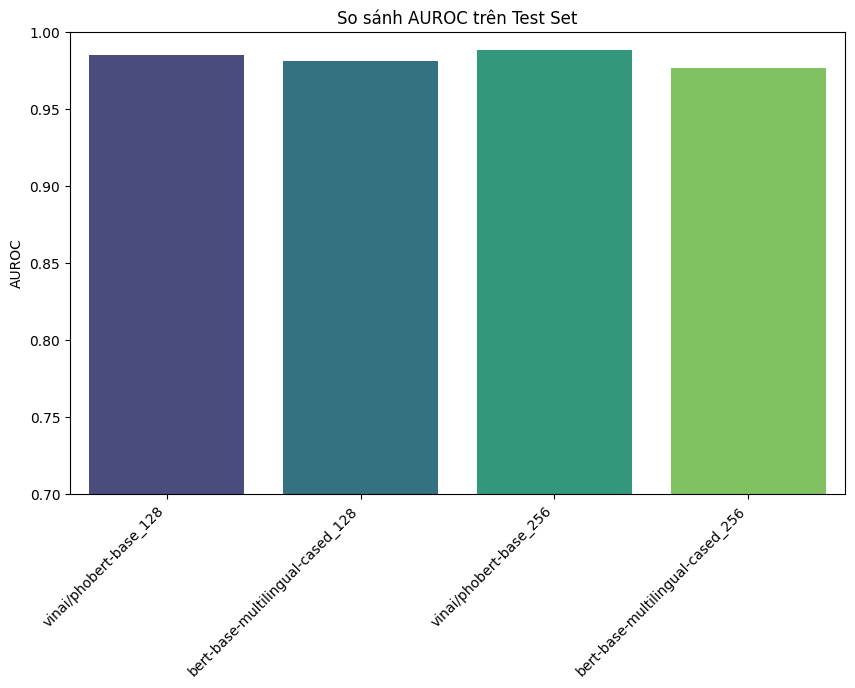

Biểu đồ lưu tại: /content/drive/MyDrive/data/outputs/test_auroc_bar.png


In [15]:
# Hàm vẽ bar chart so sánh test metrics
def plot_test_bar(test_results, output_dir, metric="f1", ylabel="F1 Macro"):
    models = list(test_results.keys())
    scores = [test_results[model][metric] for model in models]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=models, y=scores, palette="viridis")
    plt.title(f"So sánh {ylabel} trên Test Set")
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0.7, 1.0)  # Điều chỉnh theo metrics
    plot_path = os.path.join(output_dir, f"test_{metric}_bar.png")
    plt.savefig(plot_path)
    plt.show()
    print(f"Biểu đồ lưu tại: {plot_path}")

# Vẽ 4 bar chart: Loss, Acc, F1, AUROC
plot_test_bar(test_results, OUTPUT_DIR, metric="loss", ylabel="Loss")
plot_test_bar(test_results, OUTPUT_DIR, metric="acc", ylabel="Accuracy")
plot_test_bar(test_results, OUTPUT_DIR, metric="f1", ylabel="F1 Macro")
plot_test_bar(test_results, OUTPUT_DIR, metric="auroc", ylabel="AUROC")

# 10) Đánh giá cuối & lưu báo cáo